<a href="https://colab.research.google.com/github/AderiP/unet-tactile-paving-segmentation/blob/main/UnetTactilePavingSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

The U-Net model is a simple fully  convolutional neural network that is used for binary segmentation i.e foreground and background pixel-wise classification. Mainly, it consists of two parts. 

*   Contracting Path: we apply a series of conv layers and downsampling layers  (max-pooling) layers to reduce the spatial size 
*   Expanding Path: we apply a series of upsampling layers to reconstruct the spatial size of the input. 

The two parts are connected using a concatenation layers among different levels. This allows learning different features at different levels. At the end we have a simple conv 1x1 layer to reduce the number of channels to 1. 

# トレーニングを始める前に
このプログラムはデータセットをzipで圧縮して、Dropboxに置いて共有リンクからダウンロードしています。

適宜、Googleドライブにデータセット置くなどして、データセットを取り込んでください。

# ハイパーパラメータ

In [ ]:
BATCH_SIZE = 32
SEED = 100
TEST_GROUP = 0 # Number of the group used for test data (test_group=0~4)
LEARNING_RATE = 0.0001
MAX_EPOCHS = 50

ADDITIONAL_LEARNING = False
MODEL_PATH = "/content/drive/My Drive/U-Net/"

# Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from keras.models import Model, load_model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation, LeakyReLU
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils import plot_model
from keras import backend as K
import glob
import random
import cv2
from random import shuffle
import glob
import csv
import datetime
import pandas as pd
from google.colab import files

# Check operating environment

In [ ]:
!nvidia-smi
!nvcc -V
print()

!python3 --version # -> Python 3.7.15
print("TensorFlow version -> ",tf.__version__) # TensorFlow version ->  2.9.2

Wed Dec  7 19:48:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    29W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Dataset copying from Dropbox and expansion

In [ ]:
%%capture
!wget https://www.dropbox.com/s/a5wjrb866xn6b8h/img.zip
!wget https://www.dropbox.com/s/6p7rwok1nx2zvo7/mask.zip
!unzip "mask" & unzip "img"

In [ ]:
os.mkdir('img_index')
os.mkdir('mask_index')

index_img = glob.glob('img/**/*.jpg')
for img in index_img:
  shutil.copy(img,"img_index/" + os.path.basename(img))

index_mask = glob.glob('mask/**/*.png')
for mask in index_mask:
  shutil.copy(mask,"mask_index/" + os.path.basename(mask))

# Write to hyperparameters text file & Set seed

In [ ]:
time = datetime.datetime.now()
now_time = time.strftime("%Y-%m-%dT%H-%M-%S")

if ADDITIONAL_LEARNING:
  RESULT_DIR = f"/content/drive/My Drive/U-Net/{now_time} t={TEST_GROUP:d}:add"
else:
  RESULT_DIR = f"/content/drive/My Drive/U-Net/{now_time} t={TEST_GROUP:d}"

if not os.path.exists(RESULT_DIR):  # ディレクトリが存在しない場合、作成する。
    os.makedirs(RESULT_DIR, exist_ok=True)

if ADDITIONAL_LEARNING:
  textfile_name = os.path.join(RESULT_DIR,  f"{now_time} t={TEST_GROUP:d}:add parameter.txt")
else:
  textfile_name = os.path.join(RESULT_DIR,  f"{now_time} t={TEST_GROUP:d} parameter.txt")

with open(textfile_name, "w") as f:
  f.write(f"BATCH_SIZE: {str(BATCH_SIZE)}\n")
  f.write(f"SEED: {str(SEED)}\n")
  f.write(f"TEST_GROUP: {str(TEST_GROUP)}\n")
  f.write(f"LEARNING_RATE: {str(LEARNING_RATE)}\n")
  f.write(f"MAX_EPOCHS: {str(MAX_EPOCHS)}\n")
  f.write(f"ADDITIONAL_LEARNING: {str(ADDITIONAL_LEARNING)}\n")

tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

# Generators

In [ ]:
def image_generator(files, batch_size = 32, sz = (256, 256)):
  
  while True: 
    
    #extract a random batch 
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = []
    
    
    for f in batch:

        #get the masks. Note that masks are png files 
        mask = Image.open(f'mask_index/{f[:-4]}.png')
        mask = np.array(mask.resize(sz))

        #preprocess the mask 
        # mask[mask >= 2] = 0 
        mask[mask != 0 ] = 1
        
        batch_y.append(mask)

        #preprocess the raw images 
        raw = Image.open(f'img_index/{f}')
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
          raw = np.stack((raw,)*3, axis=-1)

        else:
          raw = raw[:,:,0:3]

        batch_x.append(raw)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,3)

    yield (batch_x, batch_y)      
    

# Set up training and test data

In [ ]:
seq_dirs = os.listdir('img')
shuffle(seq_dirs)

print("Order of sequence directory")
print(seq_dirs)
print()

# Group of 5 divided datasets
img_groups = []
img_group = []
seq_group = []

for i, seq_dir in enumerate(seq_dirs, 1):
  img_group.extend(os.listdir('img/'+seq_dir))
  seq_group.append(seq_dir)
  if i % 4 == 0:
    img_groups.append([img_group,seq_group])
    img_group = []
    seq_group = []

train_files = []
test_files = []

for i in range(5):
  if i == TEST_GROUP:
    print("test sequence: ", end="")
    print(img_groups[i][1])

    test_files = img_groups[i][0]
  else:
    print("traint sequence: ", end="")
    print(img_groups[i][1])

    train_files.extend(img_groups[i][0])

shuffle(train_files)
shuffle(test_files) 

print("\nfirst img")
print("train sequence: ", end="")
print(train_files[0])
print("test sequence: ", end="")
print(test_files[0])

train_generator = image_generator(train_files, batch_size = BATCH_SIZE)
test_generator  = image_generator(test_files, batch_size = BATCH_SIZE)

Order of sequence directory
['17', '09', '15', '20', '01', '07', '04', '13', '19', '02', '16', '03', '12', '06', '10', '14', '18', '08', '05', '11']

test sequence: ['17', '09', '15', '20']
traint sequence: ['01', '07', '04', '13']
traint sequence: ['19', '02', '16', '03']
traint sequence: ['12', '06', '10', '14']
traint sequence: ['18', '08', '05', '11']

first img
train sequence: VID_20210906_153203_0971.jpg
test sequence: VID_20210809_121009_0616.jpg


# IoU metric

The intersection over union (IoU) metric is a simple metric used to evaluate the performance of a segmentation algorithm. Given two masks $y_{true}, y_{pred}$ we evaluate 

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

In [ ]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

# Loss Function

In [ ]:
def dice_loss(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    y_true = tf.cast(y_true, tf.float32)

    smooth = 1. # ゼロ除算回避のための定数
    y_true_flat = tf.reshape(y_true, [-1]) # 1次元に変換
    y_pred_flat = tf.reshape(y_pred, [-1]) # 同様

    tp = tf.reduce_sum(y_true_flat * y_pred_flat) # True Positive
    nominator = 2 * tp + smooth # 分子
    denominator = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) + smooth # 分母
    score = nominator / denominator
    return 1. - score

# Model

In [ ]:
def unet(sz = (256, 256, 3)):
  x = Input(sz)
  inputs = x
  
  #down sampling 
  f = 8
  layers = []
  
  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  ff2 = 64 
  
  #bottleneck 
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1 
  
  #upsampling 
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2 
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
    
  
  #classification 
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)

  #optimaizer
  # rmsprop = RMSprop(learning_rate=LEARNING_RATE, rho=0.9, epsilon=None, decay=0.0)
  adam = Adam(learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = adam, loss = dice_loss, metrics = [mean_iou])
  
  return model

In [ ]:
model = unet()

if ADDITIONAL_LEARNING:
  model.load_weights(MODEL_PATH)

# ModelCheckpoint

In [ ]:
CHECKPOINT_DIR = os.path.join(RESULT_DIR, "checkpoint")

if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)

if ADDITIONAL_LEARNING:
  checkpoint_filepath = os.path.join(CHECKPOINT_DIR, f"{now_time} t={TEST_GROUP:d}:add " + "{epoch:03d}.h5")
else:
  checkpoint_filepath = os.path.join(CHECKPOINT_DIR, f"{now_time} t={TEST_GROUP:d} " + "{epoch:03d}.h5")

checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                             verbose = 0,
                             save_best_only=True,
                             save_weights_only=False,
                             save_freq=10)

# Callbacks

Simple functions to save the model at each epoch and show some predictions 

In [ ]:
LOG_DIR = f"/content/drive/My Drive/U-Net/logs"

if not os.path.exists(LOG_DIR):
    os.makedirs(LOG_DIR, exist_ok=True)

if ADDITIONAL_LEARNING:
  log_dir_path = os.path.join(LOG_DIR, f"{now_time} t={TEST_GROUP:d}:add")
else:
  log_dir_path = os.path.join(LOG_DIR, f"{now_time} t={TEST_GROUP:d}")

def build_callbacks():
        checkpointer = checkpoint
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir_path)
        callbacks = [checkpointer, PlotLearning(), tensorboard_callback]
        return callbacks

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        raw = Image.open(f'img_index/{path}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))
        
        #mask post-processing 
        msk  = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.5] = 1
        msk[msk < 0.5] = 0
        
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

# Training Executor

In [ ]:
def training():
  train_steps = len(train_files) //BATCH_SIZE
  test_steps = len(test_files) //BATCH_SIZE
  history = model.fit(train_generator, 
                      epochs = MAX_EPOCHS,
                      steps_per_epoch = train_steps,
                      validation_data = test_generator, 
                      validation_steps = test_steps, 
                      callbacks = build_callbacks())
  hist_df = pd.DataFrame(history.history)

  if ADDITIONAL_LEARNING:
    history_csv_path = os.path.join(RESULT_DIR, f"{now_time} t={TEST_GROUP:d}:add history.csv")
  else:
    history_csv_path = os.path.join(RESULT_DIR, f"{now_time} t={TEST_GROUP:d} history.csv")


  hist_df.to_csv(os.path.join(RESULT_DIR, f"{now_time} t={TEST_GROUP:d} history.csv"))

# Test Executor

In [ ]:
def testing():
  print("\ntest data mean iou")

  if ADDITIONAL_LEARNING:
    csv_path = os.path.join(RESULT_DIR, f"{now_time} t={TEST_GROUP:d}:add result.csv")
  else:
    csv_path = os.path.join(RESULT_DIR, f"{now_time} t={TEST_GROUP:d} result.csv")

  with open(csv_path, 'w') as f:
      writer = csv.writer(f)
      writer.writerow(["img_name","iou"])

      iou_sum = 0.0

      for i, test_file in enumerate(test_files,1):
        mask = Image.open(f'mask_index/{test_file[:-4]}.png')
        mask = np.array(mask.resize((256, 256)))

        #preprocess the mask 
        mask[mask != 0 ] = 1

        raw = Image.open(f'img_index/{test_file}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]

        #predict the mask 
        pred = model.predict_on_batch(np.expand_dims(raw, 0))

        yt0 = K.cast(mask, 'float32')
        yp0 = K.cast(pred[:,:,:,0] > 0.5, 'float32')
        inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
        union = tf.math.count_nonzero(tf.add(yt0, yp0))
        iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))

        writer.writerow([test_file, iou.numpy()])

        iou_sum = iou_sum + iou.numpy()

        if i % 1000 == 0:
          print("[{:d}/{:d}] {:f}".format(i, len(test_files), iou_sum/i))

# Run

Epoch 1/50
  9/250 [>.............................] - ETA: 2:38 - loss: 0.9379 - mean_iou: 0.0301

 19/250 [=>............................] - ETA: 2:29 - loss: 0.9361 - mean_iou: 0.0397

 29/250 [==>...........................] - ETA: 2:26 - loss: 0.9359 - mean_iou: 0.0430

 39/250 [===>..........................] - ETA: 2:20 - loss: 0.9351 - mean_iou: 0.0479

 49/250 [====>.........................] - ETA: 2:12 - loss: 0.9333 - mean_iou: 0.0596

 59/250 [======>.......................] - ETA: 2:05 - loss: 0.9279 - mean_iou: 0.0782

 69/250 [=======>......................] - ETA: 1:58 - loss: 0.9044 - mean_iou: 0.0971

 79/250 [========>.....................] - ETA: 1:51 - loss: 0.8717 - mean_iou: 0.1202

 89/250 [=========>....................] - ETA: 1:45 - loss: 0.8294 - mean_iou: 0.1493

 99/250 [==========>...................] - ETA: 1:39 - loss: 0.7898 - mean_iou: 0.1760

109/250 [============>.................] - ETA: 1:32 - loss: 0.7530 - mean_iou: 0.2023

119/250 [=============>................] - ETA: 1:26 - loss: 0.7223 - mean_iou: 0.2238

129/250 [==============>...............] - ETA: 1:19 - loss: 0.6952 - mean_iou: 0.2427

139/250 [===============>..............] - ETA: 1:12 - loss: 0.6690 - mean_iou: 0.2625

149/250 [================>.............] - ETA: 1:06 - loss: 0.6437 - mean_iou: 0.2824

159/250 [==================>...........] - ETA: 1:00 - loss: 0.6191 - mean_iou: 0.3029

169/250 [===================>..........] - ETA: 53s - loss: 0.5962 - mean_iou: 0.3227

179/250 [====================>.........] - ETA: 46s - loss: 0.5740 - mean_iou: 0.3426

189/250 [=====================>........] - ETA: 40s - loss: 0.5531 - mean_iou: 0.3620

199/250 [======================>.......] - ETA: 33s - loss: 0.5338 - mean_iou: 0.3800

209/250 [========================>.....] - ETA: 26s - loss: 0.5154 - mean_iou: 0.3977

219/250 [=========================>....] - ETA: 20s - loss: 0.4981 - mean_iou: 0.4146

229/250 [==========================>...] - ETA: 13s - loss: 0.4818 - mean_iou: 0.4309

239/250 [===========================>..] - ETA: 7s - loss: 0.4665 - mean_iou: 0.4463

249/250 [============================>.] - ETA: 0s - loss: 0.4529 - mean_iou: 0.4596

1/1 [==============================] - 1s 844ms/step


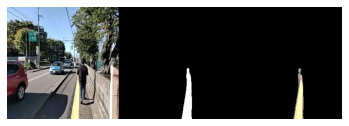

250/250 [==============================] - 219s 831ms/step - loss: 0.4517 - mean_iou: 0.4608 - val_loss: 0.2348 - val_mean_iou: 0.6228
Epoch 2/50
  9/250 [>.............................] - ETA: 2:37 - loss: 0.1221 - mean_iou: 0.7867

 19/250 [=>............................] - ETA: 2:30 - loss: 0.1163 - mean_iou: 0.7958

 29/250 [==>...........................] - ETA: 2:25 - loss: 0.1109 - mean_iou: 0.8043

 39/250 [===>..........................] - ETA: 2:21 - loss: 0.1071 - mean_iou: 0.8104

 49/250 [====>.........................] - ETA: 2:13 - loss: 0.1040 - mean_iou: 0.8153

 59/250 [======>.......................] - ETA: 2:06 - loss: 0.1023 - mean_iou: 0.8180

 69/250 [=======>......................] - ETA: 1:59 - loss: 0.1004 - mean_iou: 0.8210

 79/250 [========>.....................] - ETA: 1:52 - loss: 0.0994 - mean_iou: 0.8226

 89/250 [=========>....................] - ETA: 1:45 - loss: 0.0985 - mean_iou: 0.8240

 99/250 [==========>...................] - ETA: 1:40 - loss: 0.0976 - mean_iou: 0.8254

109/250 [============>.................] - ETA: 1:33 - loss: 0.0962 - mean_iou: 0.8276

119/250 [=============>................] - ETA: 1:26 - loss: 0.0950 - mean_iou: 0.8296

129/250 [==============>...............] - ETA: 1:19 - loss: 0.0938 - mean_iou: 0.8316

139/250 [===============>..............] - ETA: 1:13 - loss: 0.0923 - mean_iou: 0.8339

149/250 [================>.............] - ETA: 1:06 - loss: 0.0909 - mean_iou: 0.8363

159/250 [==================>...........] - ETA: 1:00 - loss: 0.0893 - mean_iou: 0.8391

169/250 [===================>..........] - ETA: 53s - loss: 0.0876 - mean_iou: 0.8418

179/250 [====================>.........] - ETA: 46s - loss: 0.0864 - mean_iou: 0.8439

189/250 [=====================>........] - ETA: 40s - loss: 0.0857 - mean_iou: 0.8450

199/250 [======================>.......] - ETA: 33s - loss: 0.0850 - mean_iou: 0.8463

209/250 [========================>.....] - ETA: 27s - loss: 0.0841 - mean_iou: 0.8478

219/250 [=========================>....] - ETA: 20s - loss: 0.0833 - mean_iou: 0.8492

229/250 [==========================>...] - ETA: 13s - loss: 0.0825 - mean_iou: 0.8504

239/250 [===========================>..] - ETA: 7s - loss: 0.0816 - mean_iou: 0.8519

249/250 [============================>.] - ETA: 0s - loss: 0.0809 - mean_iou: 0.8530

1/1 [==============================] - 0s 22ms/step


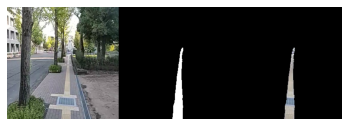

250/250 [==============================] - 197s 788ms/step - loss: 0.0808 - mean_iou: 0.8533 - val_loss: 0.1729 - val_mean_iou: 0.7066
Epoch 3/50
  9/250 [>.............................] - ETA: 2:36 - loss: 0.0560 - mean_iou: 0.8958

 19/250 [=>............................] - ETA: 2:29 - loss: 0.0580 - mean_iou: 0.8921

 29/250 [==>...........................] - ETA: 2:22 - loss: 0.0601 - mean_iou: 0.8883

 39/250 [===>..........................] - ETA: 2:16 - loss: 0.0607 - mean_iou: 0.8873

 49/250 [====>.........................] - ETA: 2:13 - loss: 0.0603 - mean_iou: 0.8879

 59/250 [======>.......................] - ETA: 2:06 - loss: 0.0601 - mean_iou: 0.8882

 69/250 [=======>......................] - ETA: 1:59 - loss: 0.0601 - mean_iou: 0.8884

 79/250 [========>.....................] - ETA: 1:52 - loss: 0.0590 - mean_iou: 0.8903

 89/250 [=========>....................] - ETA: 1:45 - loss: 0.0581 - mean_iou: 0.8918

 99/250 [==========>...................] - ETA: 1:39 - loss: 0.0577 - mean_iou: 0.8925

109/250 [============>.................] - ETA: 1:33 - loss: 0.0576 - mean_iou: 0.8927

119/250 [=============>................] - ETA: 1:26 - loss: 0.0572 - mean_iou: 0.8934

129/250 [==============>...............] - ETA: 1:20 - loss: 0.0568 - mean_iou: 0.8941

139/250 [===============>..............] - ETA: 1:13 - loss: 0.0568 - mean_iou: 0.8941

149/250 [================>.............] - ETA: 1:06 - loss: 0.0563 - mean_iou: 0.8950

159/250 [==================>...........] - ETA: 59s - loss: 0.0558 - mean_iou: 0.8959 

169/250 [===================>..........] - ETA: 53s - loss: 0.0554 - mean_iou: 0.8967

179/250 [====================>.........] - ETA: 47s - loss: 0.0549 - mean_iou: 0.8974

189/250 [=====================>........] - ETA: 40s - loss: 0.0544 - mean_iou: 0.8983

199/250 [======================>.......] - ETA: 33s - loss: 0.0540 - mean_iou: 0.8991

209/250 [========================>.....] - ETA: 27s - loss: 0.0536 - mean_iou: 0.8999

219/250 [=========================>....] - ETA: 20s - loss: 0.0532 - mean_iou: 0.9006

229/250 [==========================>...] - ETA: 13s - loss: 0.0530 - mean_iou: 0.9008

239/250 [===========================>..] - ETA: 7s - loss: 0.0529 - mean_iou: 0.9010

249/250 [============================>.] - ETA: 0s - loss: 0.0528 - mean_iou: 0.9013

1/1 [==============================] - 0s 23ms/step


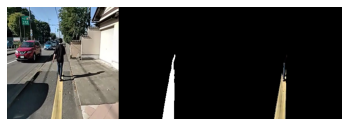

250/250 [==============================] - 207s 827ms/step - loss: 0.0528 - mean_iou: 0.9011 - val_loss: 0.1570 - val_mean_iou: 0.7297
Epoch 4/50
  9/250 [>.............................] - ETA: 2:37 - loss: 0.0463 - mean_iou: 0.9128

 19/250 [=>............................] - ETA: 2:30 - loss: 0.0523 - mean_iou: 0.9018

 29/250 [==>...........................] - ETA: 2:23 - loss: 0.0623 - mean_iou: 0.8843

 39/250 [===>..........................] - ETA: 2:17 - loss: 0.0631 - mean_iou: 0.8828

 49/250 [====>.........................] - ETA: 2:13 - loss: 0.0640 - mean_iou: 0.8812

 59/250 [======>.......................] - ETA: 2:06 - loss: 0.0640 - mean_iou: 0.8810

 69/250 [=======>......................] - ETA: 1:59 - loss: 0.0641 - mean_iou: 0.8809

 79/250 [========>.....................] - ETA: 1:52 - loss: 0.0641 - mean_iou: 0.8808

 89/250 [=========>....................] - ETA: 1:45 - loss: 0.0630 - mean_iou: 0.8828

 99/250 [==========>...................] - ETA: 1:39 - loss: 0.0622 - mean_iou: 0.8842

109/250 [============>.................] - ETA: 1:33 - loss: 0.0610 - mean_iou: 0.8861

119/250 [=============>................] - ETA: 1:26 - loss: 0.0602 - mean_iou: 0.8876

129/250 [==============>...............] - ETA: 1:20 - loss: 0.0592 - mean_iou: 0.8895

139/250 [===============>..............] - ETA: 1:13 - loss: 0.0584 - mean_iou: 0.8909

149/250 [================>.............] - ETA: 1:06 - loss: 0.0577 - mean_iou: 0.8920

159/250 [==================>...........] - ETA: 1:00 - loss: 0.0571 - mean_iou: 0.8931

169/250 [===================>..........] - ETA: 53s - loss: 0.0564 - mean_iou: 0.8943

179/250 [====================>.........] - ETA: 47s - loss: 0.0558 - mean_iou: 0.8955

189/250 [=====================>........] - ETA: 40s - loss: 0.0552 - mean_iou: 0.8966

199/250 [======================>.......] - ETA: 33s - loss: 0.0545 - mean_iou: 0.8978

209/250 [========================>.....] - ETA: 27s - loss: 0.0538 - mean_iou: 0.8990

219/250 [=========================>....] - ETA: 20s - loss: 0.0532 - mean_iou: 0.9001

229/250 [==========================>...] - ETA: 13s - loss: 0.0528 - mean_iou: 0.9008

239/250 [===========================>..] - ETA: 7s - loss: 0.0525 - mean_iou: 0.9014

249/250 [============================>.] - ETA: 0s - loss: 0.0521 - mean_iou: 0.9021

1/1 [==============================] - 0s 23ms/step


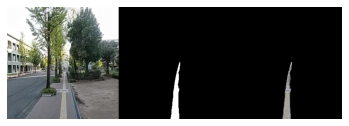

250/250 [==============================] - 207s 828ms/step - loss: 0.0520 - mean_iou: 0.9023 - val_loss: 0.1498 - val_mean_iou: 0.7403
Epoch 5/50
  9/250 [>.............................] - ETA: 2:35 - loss: 0.0424 - mean_iou: 0.9196

 19/250 [=>............................] - ETA: 2:29 - loss: 0.0419 - mean_iou: 0.9206

 29/250 [==>...........................] - ETA: 2:23 - loss: 0.0405 - mean_iou: 0.9230

 39/250 [===>..........................] - ETA: 2:16 - loss: 0.0404 - mean_iou: 0.9232

 49/250 [====>.........................] - ETA: 2:13 - loss: 0.0412 - mean_iou: 0.9218

 59/250 [======>.......................] - ETA: 2:05 - loss: 0.0414 - mean_iou: 0.9215

 69/250 [=======>......................] - ETA: 1:59 - loss: 0.0406 - mean_iou: 0.9229

 79/250 [========>.....................] - ETA: 1:52 - loss: 0.0398 - mean_iou: 0.9244

 89/250 [=========>....................] - ETA: 1:45 - loss: 0.0396 - mean_iou: 0.9246

 99/250 [==========>...................] - ETA: 1:38 - loss: 0.0392 - mean_iou: 0.9254

109/250 [============>.................] - ETA: 1:33 - loss: 0.0389 - mean_iou: 0.9259

119/250 [=============>................] - ETA: 1:26 - loss: 0.0388 - mean_iou: 0.9260

129/250 [==============>...............] - ETA: 1:19 - loss: 0.0389 - mean_iou: 0.9259

139/250 [===============>..............] - ETA: 1:13 - loss: 0.0390 - mean_iou: 0.9257

149/250 [================>.............] - ETA: 1:06 - loss: 0.0388 - mean_iou: 0.9261

159/250 [==================>...........] - ETA: 59s - loss: 0.0390 - mean_iou: 0.9258 

169/250 [===================>..........] - ETA: 53s - loss: 0.0389 - mean_iou: 0.9260

179/250 [====================>.........] - ETA: 46s - loss: 0.0388 - mean_iou: 0.9262

189/250 [=====================>........] - ETA: 40s - loss: 0.0386 - mean_iou: 0.9265

199/250 [======================>.......] - ETA: 33s - loss: 0.0386 - mean_iou: 0.9265

209/250 [========================>.....] - ETA: 27s - loss: 0.0383 - mean_iou: 0.9269

219/250 [=========================>....] - ETA: 20s - loss: 0.0383 - mean_iou: 0.9269

229/250 [==========================>...] - ETA: 13s - loss: 0.0383 - mean_iou: 0.9269

239/250 [===========================>..] - ETA: 7s - loss: 0.0382 - mean_iou: 0.9272

249/250 [============================>.] - ETA: 0s - loss: 0.0381 - mean_iou: 0.9274

1/1 [==============================] - 0s 24ms/step


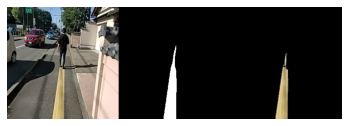

250/250 [==============================] - 207s 830ms/step - loss: 0.0381 - mean_iou: 0.9274 - val_loss: 0.1473 - val_mean_iou: 0.7441
Epoch 6/50
  9/250 [>.............................] - ETA: 2:35 - loss: 0.0352 - mean_iou: 0.9325

 19/250 [=>............................] - ETA: 2:29 - loss: 0.0343 - mean_iou: 0.9344

 29/250 [==>...........................] - ETA: 2:23 - loss: 0.0344 - mean_iou: 0.9341

 39/250 [===>..........................] - ETA: 2:21 - loss: 0.0344 - mean_iou: 0.9342

 49/250 [====>.........................] - ETA: 2:13 - loss: 0.0336 - mean_iou: 0.9356

 59/250 [======>.......................] - ETA: 2:06 - loss: 0.0332 - mean_iou: 0.9363

 69/250 [=======>......................] - ETA: 1:59 - loss: 0.0335 - mean_iou: 0.9359

 79/250 [========>.....................] - ETA: 1:52 - loss: 0.0332 - mean_iou: 0.9363

 89/250 [=========>....................] - ETA: 1:45 - loss: 0.0334 - mean_iou: 0.9360

 99/250 [==========>...................] - ETA: 1:39 - loss: 0.0332 - mean_iou: 0.9365

109/250 [============>.................] - ETA: 1:33 - loss: 0.0332 - mean_iou: 0.9363

119/250 [=============>................] - ETA: 1:26 - loss: 0.0332 - mean_iou: 0.9364

129/250 [==============>...............] - ETA: 1:19 - loss: 0.0332 - mean_iou: 0.9364

139/250 [===============>..............] - ETA: 1:13 - loss: 0.0329 - mean_iou: 0.9369

149/250 [================>.............] - ETA: 1:06 - loss: 0.0329 - mean_iou: 0.9369

159/250 [==================>...........] - ETA: 59s - loss: 0.0329 - mean_iou: 0.9370 

169/250 [===================>..........] - ETA: 53s - loss: 0.0329 - mean_iou: 0.9370

179/250 [====================>.........] - ETA: 46s - loss: 0.0330 - mean_iou: 0.9368

189/250 [=====================>........] - ETA: 40s - loss: 0.0330 - mean_iou: 0.9367

199/250 [======================>.......] - ETA: 33s - loss: 0.0329 - mean_iou: 0.9369

209/250 [========================>.....] - ETA: 27s - loss: 0.0332 - mean_iou: 0.9364

219/250 [=========================>....] - ETA: 20s - loss: 0.0330 - mean_iou: 0.9367

229/250 [==========================>...] - ETA: 13s - loss: 0.0330 - mean_iou: 0.9368

239/250 [===========================>..] - ETA: 7s - loss: 0.0331 - mean_iou: 0.9366

249/250 [============================>.] - ETA: 0s - loss: 0.0331 - mean_iou: 0.9366

1/1 [==============================] - 0s 22ms/step


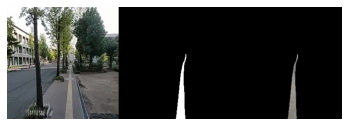

250/250 [==============================] - 197s 787ms/step - loss: 0.0331 - mean_iou: 0.9366 - val_loss: 0.1487 - val_mean_iou: 0.7419
Epoch 7/50
  9/250 [>.............................] - ETA: 2:36 - loss: 0.0350 - mean_iou: 0.9329

 19/250 [=>............................] - ETA: 2:29 - loss: 0.0350 - mean_iou: 0.9331

 29/250 [==>...........................] - ETA: 2:22 - loss: 0.0339 - mean_iou: 0.9350

 39/250 [===>..........................] - ETA: 2:16 - loss: 0.0337 - mean_iou: 0.9354

 49/250 [====>.........................] - ETA: 2:10 - loss: 0.0323 - mean_iou: 0.9380

 59/250 [======>.......................] - ETA: 2:06 - loss: 0.0326 - mean_iou: 0.9375

 69/250 [=======>......................] - ETA: 1:59 - loss: 0.0322 - mean_iou: 0.9382

 79/250 [========>.....................] - ETA: 1:52 - loss: 0.0320 - mean_iou: 0.9387

 89/250 [=========>....................] - ETA: 1:45 - loss: 0.0317 - mean_iou: 0.9392

 99/250 [==========>...................] - ETA: 1:38 - loss: 0.0317 - mean_iou: 0.9392

109/250 [============>.................] - ETA: 1:32 - loss: 0.0319 - mean_iou: 0.9388

119/250 [=============>................] - ETA: 1:26 - loss: 0.0314 - mean_iou: 0.9397

129/250 [==============>...............] - ETA: 1:19 - loss: 0.0313 - mean_iou: 0.9399

139/250 [===============>..............] - ETA: 1:13 - loss: 0.0312 - mean_iou: 0.9401

149/250 [================>.............] - ETA: 1:06 - loss: 0.0310 - mean_iou: 0.9404

159/250 [==================>...........] - ETA: 59s - loss: 0.0310 - mean_iou: 0.9404 

169/250 [===================>..........] - ETA: 53s - loss: 0.0309 - mean_iou: 0.9407

179/250 [====================>.........] - ETA: 46s - loss: 0.0309 - mean_iou: 0.9407

189/250 [=====================>........] - ETA: 40s - loss: 0.0308 - mean_iou: 0.9408

199/250 [======================>.......] - ETA: 33s - loss: 0.0309 - mean_iou: 0.9407

209/250 [========================>.....] - ETA: 27s - loss: 0.0306 - mean_iou: 0.9412

219/250 [=========================>....] - ETA: 20s - loss: 0.0305 - mean_iou: 0.9415

229/250 [==========================>...] - ETA: 13s - loss: 0.0304 - mean_iou: 0.9416

239/250 [===========================>..] - ETA: 7s - loss: 0.0302 - mean_iou: 0.9420

249/250 [============================>.] - ETA: 0s - loss: 0.0300 - mean_iou: 0.9423

1/1 [==============================] - 0s 22ms/step


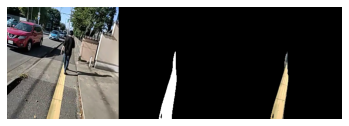

250/250 [==============================] - 195s 782ms/step - loss: 0.0300 - mean_iou: 0.9423 - val_loss: 0.1473 - val_mean_iou: 0.7439
Epoch 8/50
  9/250 [>.............................] - ETA: 2:35 - loss: 0.0297 - mean_iou: 0.9431

 19/250 [=>............................] - ETA: 2:39 - loss: 0.0299 - mean_iou: 0.9426

 29/250 [==>...........................] - ETA: 2:29 - loss: 0.0296 - mean_iou: 0.9431

 39/250 [===>..........................] - ETA: 2:21 - loss: 0.0288 - mean_iou: 0.9446

 49/250 [====>.........................] - ETA: 2:13 - loss: 0.0289 - mean_iou: 0.9444

 59/250 [======>.......................] - ETA: 2:06 - loss: 0.0288 - mean_iou: 0.9446

 69/250 [=======>......................] - ETA: 1:59 - loss: 0.0296 - mean_iou: 0.9431

 79/250 [========>.....................] - ETA: 1:54 - loss: 0.0293 - mean_iou: 0.9437

 89/250 [=========>....................] - ETA: 1:47 - loss: 0.0289 - mean_iou: 0.9444

 99/250 [==========>...................] - ETA: 1:40 - loss: 0.0288 - mean_iou: 0.9446

109/250 [============>.................] - ETA: 1:33 - loss: 0.0286 - mean_iou: 0.9449

119/250 [=============>................] - ETA: 1:26 - loss: 0.0287 - mean_iou: 0.9447

129/250 [==============>...............] - ETA: 1:20 - loss: 0.0289 - mean_iou: 0.9445

139/250 [===============>..............] - ETA: 1:13 - loss: 0.0289 - mean_iou: 0.9444

149/250 [================>.............] - ETA: 1:07 - loss: 0.0287 - mean_iou: 0.9447

159/250 [==================>...........] - ETA: 1:00 - loss: 0.0285 - mean_iou: 0.9452

169/250 [===================>..........] - ETA: 53s - loss: 0.0287 - mean_iou: 0.9448

179/250 [====================>.........] - ETA: 47s - loss: 0.0285 - mean_iou: 0.9451

189/250 [=====================>........] - ETA: 40s - loss: 0.0284 - mean_iou: 0.9453

199/250 [======================>.......] - ETA: 33s - loss: 0.0285 - mean_iou: 0.9452

209/250 [========================>.....] - ETA: 27s - loss: 0.0284 - mean_iou: 0.9454

219/250 [=========================>....] - ETA: 20s - loss: 0.0283 - mean_iou: 0.9456

229/250 [==========================>...] - ETA: 13s - loss: 0.0284 - mean_iou: 0.9455

239/250 [===========================>..] - ETA: 7s - loss: 0.0283 - mean_iou: 0.9456

249/250 [============================>.] - ETA: 0s - loss: 0.0283 - mean_iou: 0.9455

1/1 [==============================] - 0s 23ms/step


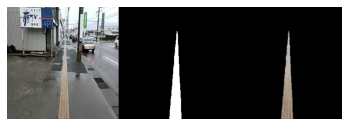

250/250 [==============================] - 208s 831ms/step - loss: 0.0283 - mean_iou: 0.9456 - val_loss: 0.1437 - val_mean_iou: 0.7496
Epoch 9/50
  9/250 [>.............................] - ETA: 2:40 - loss: 0.0250 - mean_iou: 0.9517

 19/250 [=>............................] - ETA: 2:39 - loss: 0.0249 - mean_iou: 0.9517

 29/250 [==>...........................] - ETA: 2:29 - loss: 0.0270 - mean_iou: 0.9479

 39/250 [===>..........................] - ETA: 2:20 - loss: 0.0267 - mean_iou: 0.9485

 49/250 [====>.........................] - ETA: 2:13 - loss: 0.0279 - mean_iou: 0.9463

 59/250 [======>.......................] - ETA: 2:06 - loss: 0.0281 - mean_iou: 0.9460

 69/250 [=======>......................] - ETA: 1:59 - loss: 0.0282 - mean_iou: 0.9458

 79/250 [========>.....................] - ETA: 1:54 - loss: 0.0282 - mean_iou: 0.9458

 89/250 [=========>....................] - ETA: 1:47 - loss: 0.0281 - mean_iou: 0.9460

 99/250 [==========>...................] - ETA: 1:40 - loss: 0.0279 - mean_iou: 0.9462

109/250 [============>.................] - ETA: 1:33 - loss: 0.0279 - mean_iou: 0.9462

119/250 [=============>................] - ETA: 1:26 - loss: 0.0280 - mean_iou: 0.9461

129/250 [==============>...............] - ETA: 1:19 - loss: 0.0283 - mean_iou: 0.9456

139/250 [===============>..............] - ETA: 1:13 - loss: 0.0280 - mean_iou: 0.9461

149/250 [================>.............] - ETA: 1:07 - loss: 0.0282 - mean_iou: 0.9457

159/250 [==================>...........] - ETA: 1:00 - loss: 0.0286 - mean_iou: 0.9449

169/250 [===================>..........] - ETA: 53s - loss: 0.0286 - mean_iou: 0.9449

179/250 [====================>.........] - ETA: 46s - loss: 0.0286 - mean_iou: 0.9450

189/250 [=====================>........] - ETA: 40s - loss: 0.0285 - mean_iou: 0.9452

199/250 [======================>.......] - ETA: 33s - loss: 0.0286 - mean_iou: 0.9450

209/250 [========================>.....] - ETA: 27s - loss: 0.0285 - mean_iou: 0.9452

219/250 [=========================>....] - ETA: 20s - loss: 0.0287 - mean_iou: 0.9447

229/250 [==========================>...] - ETA: 13s - loss: 0.0286 - mean_iou: 0.9450

239/250 [===========================>..] - ETA: 7s - loss: 0.0287 - mean_iou: 0.9448

249/250 [============================>.] - ETA: 0s - loss: 0.0286 - mean_iou: 0.9451

1/1 [==============================] - 0s 22ms/step


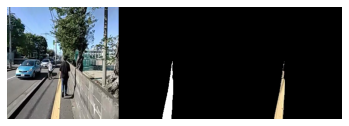

250/250 [==============================] - 197s 788ms/step - loss: 0.0285 - mean_iou: 0.9451 - val_loss: 0.1387 - val_mean_iou: 0.7573
Epoch 10/50
  9/250 [>.............................] - ETA: 2:35 - loss: 0.0230 - mean_iou: 0.9555

 19/250 [=>............................] - ETA: 2:29 - loss: 0.0234 - mean_iou: 0.9548

 29/250 [==>...........................] - ETA: 2:29 - loss: 0.0230 - mean_iou: 0.9555

 39/250 [===>..........................] - ETA: 2:21 - loss: 0.0235 - mean_iou: 0.9545

 49/250 [====>.........................] - ETA: 2:13 - loss: 0.0236 - mean_iou: 0.9542

 59/250 [======>.......................] - ETA: 2:06 - loss: 0.0240 - mean_iou: 0.9536

 69/250 [=======>......................] - ETA: 1:59 - loss: 0.0240 - mean_iou: 0.9536

 79/250 [========>.....................] - ETA: 1:52 - loss: 0.0246 - mean_iou: 0.9523

 89/250 [=========>....................] - ETA: 1:47 - loss: 0.0250 - mean_iou: 0.9516

 99/250 [==========>...................] - ETA: 1:40 - loss: 0.0261 - mean_iou: 0.9497

109/250 [============>.................] - ETA: 1:33 - loss: 0.0264 - mean_iou: 0.9491

119/250 [=============>................] - ETA: 1:26 - loss: 0.0261 - mean_iou: 0.9496

129/250 [==============>...............] - ETA: 1:19 - loss: 0.0260 - mean_iou: 0.9498

139/250 [===============>..............] - ETA: 1:13 - loss: 0.0260 - mean_iou: 0.9499

149/250 [================>.............] - ETA: 1:07 - loss: 0.0257 - mean_iou: 0.9504

159/250 [==================>...........] - ETA: 1:00 - loss: 0.0259 - mean_iou: 0.9501

169/250 [===================>..........] - ETA: 53s - loss: 0.0257 - mean_iou: 0.9503

179/250 [====================>.........] - ETA: 47s - loss: 0.0259 - mean_iou: 0.9501

189/250 [=====================>........] - ETA: 40s - loss: 0.0257 - mean_iou: 0.9503

199/250 [======================>.......] - ETA: 33s - loss: 0.0255 - mean_iou: 0.9507

209/250 [========================>.....] - ETA: 27s - loss: 0.0255 - mean_iou: 0.9508

219/250 [=========================>....] - ETA: 20s - loss: 0.0254 - mean_iou: 0.9510

229/250 [==========================>...] - ETA: 13s - loss: 0.0252 - mean_iou: 0.9513

239/250 [===========================>..] - ETA: 7s - loss: 0.0252 - mean_iou: 0.9513

249/250 [============================>.] - ETA: 0s - loss: 0.0252 - mean_iou: 0.9513

1/1 [==============================] - 0s 22ms/step


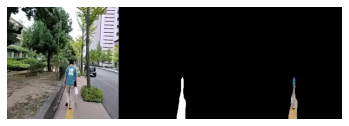

250/250 [==============================] - 197s 787ms/step - loss: 0.0253 - mean_iou: 0.9512 - val_loss: 0.1351 - val_mean_iou: 0.7628
Epoch 11/50
  9/250 [>.............................] - ETA: 2:35 - loss: 0.0276 - mean_iou: 0.9470

 19/250 [=>............................] - ETA: 2:28 - loss: 0.0259 - mean_iou: 0.9500

 29/250 [==>...........................] - ETA: 2:22 - loss: 0.0251 - mean_iou: 0.9514

 39/250 [===>..........................] - ETA: 2:19 - loss: 0.0261 - mean_iou: 0.9497

 49/250 [====>.........................] - ETA: 2:12 - loss: 0.0257 - mean_iou: 0.9503

 59/250 [======>.......................] - ETA: 2:05 - loss: 0.0258 - mean_iou: 0.9503

 69/250 [=======>......................] - ETA: 1:58 - loss: 0.0257 - mean_iou: 0.9503

 79/250 [========>.....................] - ETA: 1:51 - loss: 0.0259 - mean_iou: 0.9501

 89/250 [=========>....................] - ETA: 1:44 - loss: 0.0254 - mean_iou: 0.9510

 99/250 [==========>...................] - ETA: 1:39 - loss: 0.0254 - mean_iou: 0.9510

109/250 [============>.................] - ETA: 1:32 - loss: 0.0253 - mean_iou: 0.9511

119/250 [=============>................] - ETA: 1:25 - loss: 0.0251 - mean_iou: 0.9514

129/250 [==============>...............] - ETA: 1:19 - loss: 0.0251 - mean_iou: 0.9514

139/250 [===============>..............] - ETA: 1:12 - loss: 0.0252 - mean_iou: 0.9513

149/250 [================>.............] - ETA: 1:05 - loss: 0.0251 - mean_iou: 0.9514

159/250 [==================>...........] - ETA: 59s - loss: 0.0252 - mean_iou: 0.9513 

169/250 [===================>..........] - ETA: 53s - loss: 0.0250 - mean_iou: 0.9517

179/250 [====================>.........] - ETA: 46s - loss: 0.0249 - mean_iou: 0.9519

189/250 [=====================>........] - ETA: 39s - loss: 0.0247 - mean_iou: 0.9523

199/250 [======================>.......] - ETA: 33s - loss: 0.0246 - mean_iou: 0.9525

209/250 [========================>.....] - ETA: 26s - loss: 0.0247 - mean_iou: 0.9523

219/250 [=========================>....] - ETA: 20s - loss: 0.0248 - mean_iou: 0.9521

229/250 [==========================>...] - ETA: 13s - loss: 0.0247 - mean_iou: 0.9523

239/250 [===========================>..] - ETA: 7s - loss: 0.0245 - mean_iou: 0.9526

249/250 [============================>.] - ETA: 0s - loss: 0.0246 - mean_iou: 0.9525

1/1 [==============================] - 0s 23ms/step


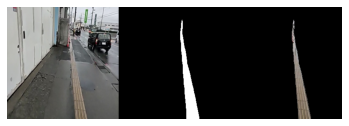

250/250 [==============================] - 194s 777ms/step - loss: 0.0245 - mean_iou: 0.9526 - val_loss: 0.1365 - val_mean_iou: 0.7604
Epoch 12/50
  9/250 [>.............................] - ETA: 2:35 - loss: 0.0234 - mean_iou: 0.9548

 19/250 [=>............................] - ETA: 2:28 - loss: 0.0227 - mean_iou: 0.9560

 29/250 [==>...........................] - ETA: 2:22 - loss: 0.0243 - mean_iou: 0.9529

 39/250 [===>..........................] - ETA: 2:16 - loss: 0.0251 - mean_iou: 0.9515

 49/250 [====>.........................] - ETA: 2:12 - loss: 0.0245 - mean_iou: 0.9526

 59/250 [======>.......................] - ETA: 2:05 - loss: 0.0241 - mean_iou: 0.9533

 69/250 [=======>......................] - ETA: 1:59 - loss: 0.0243 - mean_iou: 0.9530

 79/250 [========>.....................] - ETA: 1:52 - loss: 0.0249 - mean_iou: 0.9519

 89/250 [=========>....................] - ETA: 1:45 - loss: 0.0246 - mean_iou: 0.9523

 99/250 [==========>...................] - ETA: 1:39 - loss: 0.0245 - mean_iou: 0.9525

109/250 [============>.................] - ETA: 1:33 - loss: 0.0244 - mean_iou: 0.9528

119/250 [=============>................] - ETA: 1:26 - loss: 0.0243 - mean_iou: 0.9530

129/250 [==============>...............] - ETA: 1:19 - loss: 0.0241 - mean_iou: 0.9533

139/250 [===============>..............] - ETA: 1:13 - loss: 0.0240 - mean_iou: 0.9535

149/250 [================>.............] - ETA: 1:06 - loss: 0.0239 - mean_iou: 0.9538

159/250 [==================>...........] - ETA: 59s - loss: 0.0237 - mean_iou: 0.9541 

169/250 [===================>..........] - ETA: 53s - loss: 0.0235 - mean_iou: 0.9544

179/250 [====================>.........] - ETA: 46s - loss: 0.0234 - mean_iou: 0.9547

189/250 [=====================>........] - ETA: 40s - loss: 0.0232 - mean_iou: 0.9549

199/250 [======================>.......] - ETA: 33s - loss: 0.0232 - mean_iou: 0.9551

209/250 [========================>.....] - ETA: 27s - loss: 0.0233 - mean_iou: 0.9549

219/250 [=========================>....] - ETA: 20s - loss: 0.0232 - mean_iou: 0.9550

229/250 [==========================>...] - ETA: 13s - loss: 0.0233 - mean_iou: 0.9549

239/250 [===========================>..] - ETA: 7s - loss: 0.0232 - mean_iou: 0.9550

249/250 [============================>.] - ETA: 0s - loss: 0.0232 - mean_iou: 0.9551

1/1 [==============================] - 0s 23ms/step


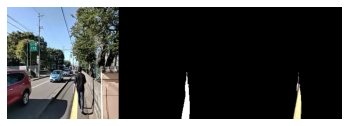

250/250 [==============================] - 195s 780ms/step - loss: 0.0232 - mean_iou: 0.9551 - val_loss: 0.1257 - val_mean_iou: 0.7773
Epoch 13/50
  9/250 [>.............................] - ETA: 2:36 - loss: 0.0211 - mean_iou: 0.9590

 19/250 [=>............................] - ETA: 2:38 - loss: 0.0227 - mean_iou: 0.9559

 29/250 [==>...........................] - ETA: 2:29 - loss: 0.0233 - mean_iou: 0.9547

 39/250 [===>..........................] - ETA: 2:20 - loss: 0.0227 - mean_iou: 0.9559

 49/250 [====>.........................] - ETA: 2:13 - loss: 0.0225 - mean_iou: 0.9563

 59/250 [======>.......................] - ETA: 2:06 - loss: 0.0223 - mean_iou: 0.9567

 69/250 [=======>......................] - ETA: 1:59 - loss: 0.0221 - mean_iou: 0.9570

 79/250 [========>.....................] - ETA: 1:54 - loss: 0.0222 - mean_iou: 0.9569

 89/250 [=========>....................] - ETA: 1:47 - loss: 0.0224 - mean_iou: 0.9566

 99/250 [==========>...................] - ETA: 1:40 - loss: 0.0225 - mean_iou: 0.9563

109/250 [============>.................] - ETA: 1:33 - loss: 0.0223 - mean_iou: 0.9567

119/250 [=============>................] - ETA: 1:26 - loss: 0.0221 - mean_iou: 0.9570

129/250 [==============>...............] - ETA: 1:19 - loss: 0.0222 - mean_iou: 0.9570

139/250 [===============>..............] - ETA: 1:13 - loss: 0.0222 - mean_iou: 0.9569

149/250 [================>.............] - ETA: 1:07 - loss: 0.0224 - mean_iou: 0.9566

159/250 [==================>...........] - ETA: 1:00 - loss: 0.0223 - mean_iou: 0.9567

169/250 [===================>..........] - ETA: 53s - loss: 0.0223 - mean_iou: 0.9568

179/250 [====================>.........] - ETA: 46s - loss: 0.0224 - mean_iou: 0.9565

189/250 [=====================>........] - ETA: 40s - loss: 0.0226 - mean_iou: 0.9561

199/250 [======================>.......] - ETA: 33s - loss: 0.0226 - mean_iou: 0.9561

209/250 [========================>.....] - ETA: 27s - loss: 0.0226 - mean_iou: 0.9562

219/250 [=========================>....] - ETA: 20s - loss: 0.0224 - mean_iou: 0.9565

229/250 [==========================>...] - ETA: 13s - loss: 0.0224 - mean_iou: 0.9565

239/250 [===========================>..] - ETA: 7s - loss: 0.0224 - mean_iou: 0.9565

249/250 [============================>.] - ETA: 0s - loss: 0.0225 - mean_iou: 0.9564

1/1 [==============================] - 0s 22ms/step


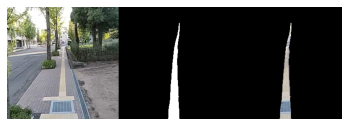

250/250 [==============================] - 196s 785ms/step - loss: 0.0224 - mean_iou: 0.9565 - val_loss: 0.1410 - val_mean_iou: 0.7536
Epoch 14/50
  9/250 [>.............................] - ETA: 2:36 - loss: 0.0254 - mean_iou: 0.9508

 19/250 [=>............................] - ETA: 2:29 - loss: 0.0247 - mean_iou: 0.9522

 29/250 [==>...........................] - ETA: 2:28 - loss: 0.0242 - mean_iou: 0.9532

 39/250 [===>..........................] - ETA: 2:20 - loss: 0.0230 - mean_iou: 0.9554

 49/250 [====>.........................] - ETA: 2:13 - loss: 0.0237 - mean_iou: 0.9540

 59/250 [======>.......................] - ETA: 2:06 - loss: 0.0230 - mean_iou: 0.9553

 69/250 [=======>......................] - ETA: 1:59 - loss: 0.0223 - mean_iou: 0.9567

 79/250 [========>.....................] - ETA: 1:52 - loss: 0.0220 - mean_iou: 0.9574

 89/250 [=========>....................] - ETA: 1:46 - loss: 0.0222 - mean_iou: 0.9570

 99/250 [==========>...................] - ETA: 1:40 - loss: 0.0222 - mean_iou: 0.9569

109/250 [============>.................] - ETA: 1:33 - loss: 0.0224 - mean_iou: 0.9566

119/250 [=============>................] - ETA: 1:26 - loss: 0.0224 - mean_iou: 0.9565

129/250 [==============>...............] - ETA: 1:19 - loss: 0.0226 - mean_iou: 0.9561

139/250 [===============>..............] - ETA: 1:13 - loss: 0.0226 - mean_iou: 0.9562

149/250 [================>.............] - ETA: 1:07 - loss: 0.0224 - mean_iou: 0.9566

159/250 [==================>...........] - ETA: 1:00 - loss: 0.0224 - mean_iou: 0.9565

169/250 [===================>..........] - ETA: 53s - loss: 0.0223 - mean_iou: 0.9568

179/250 [====================>.........] - ETA: 46s - loss: 0.0226 - mean_iou: 0.9563

189/250 [=====================>........] - ETA: 40s - loss: 0.0226 - mean_iou: 0.9561

199/250 [======================>.......] - ETA: 33s - loss: 0.0225 - mean_iou: 0.9564

209/250 [========================>.....] - ETA: 27s - loss: 0.0224 - mean_iou: 0.9566

219/250 [=========================>....] - ETA: 20s - loss: 0.0222 - mean_iou: 0.9568

229/250 [==========================>...] - ETA: 13s - loss: 0.0224 - mean_iou: 0.9566

239/250 [===========================>..] - ETA: 7s - loss: 0.0224 - mean_iou: 0.9566

249/250 [============================>.] - ETA: 0s - loss: 0.0224 - mean_iou: 0.9566

1/1 [==============================] - 0s 22ms/step


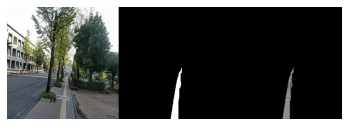

250/250 [==============================] - 196s 784ms/step - loss: 0.0224 - mean_iou: 0.9566 - val_loss: 0.1365 - val_mean_iou: 0.7603
Epoch 15/50
  9/250 [>.............................] - ETA: 2:36 - loss: 0.0233 - mean_iou: 0.9549

 19/250 [=>............................] - ETA: 2:30 - loss: 0.0244 - mean_iou: 0.9529

 29/250 [==>...........................] - ETA: 2:23 - loss: 0.0233 - mean_iou: 0.9548

 39/250 [===>..........................] - ETA: 2:21 - loss: 0.0231 - mean_iou: 0.9551

 49/250 [====>.........................] - ETA: 2:13 - loss: 0.0228 - mean_iou: 0.9558

 59/250 [======>.......................] - ETA: 2:06 - loss: 0.0224 - mean_iou: 0.9566

 69/250 [=======>......................] - ETA: 1:59 - loss: 0.0222 - mean_iou: 0.9569

 79/250 [========>.....................] - ETA: 1:53 - loss: 0.0218 - mean_iou: 0.9576

 89/250 [=========>....................] - ETA: 1:46 - loss: 0.0216 - mean_iou: 0.9581

 99/250 [==========>...................] - ETA: 1:40 - loss: 0.0222 - mean_iou: 0.9570

109/250 [============>.................] - ETA: 1:33 - loss: 0.0221 - mean_iou: 0.9571

119/250 [=============>................] - ETA: 1:26 - loss: 0.0221 - mean_iou: 0.9570

129/250 [==============>...............] - ETA: 1:20 - loss: 0.0223 - mean_iou: 0.9568

139/250 [===============>..............] - ETA: 1:13 - loss: 0.0222 - mean_iou: 0.9569

149/250 [================>.............] - ETA: 1:06 - loss: 0.0225 - mean_iou: 0.9563

159/250 [==================>...........] - ETA: 1:00 - loss: 0.0228 - mean_iou: 0.9558

169/250 [===================>..........] - ETA: 53s - loss: 0.0228 - mean_iou: 0.9557

179/250 [====================>.........] - ETA: 47s - loss: 0.0228 - mean_iou: 0.9558

189/250 [=====================>........] - ETA: 40s - loss: 0.0227 - mean_iou: 0.9560

199/250 [======================>.......] - ETA: 33s - loss: 0.0226 - mean_iou: 0.9562

209/250 [========================>.....] - ETA: 27s - loss: 0.0225 - mean_iou: 0.9563

219/250 [=========================>....] - ETA: 20s - loss: 0.0225 - mean_iou: 0.9563

229/250 [==========================>...] - ETA: 14s - loss: 0.0223 - mean_iou: 0.9567

239/250 [===========================>..] - ETA: 7s - loss: 0.0225 - mean_iou: 0.9564

249/250 [============================>.] - ETA: 0s - loss: 0.0226 - mean_iou: 0.9562

1/1 [==============================] - 0s 24ms/step


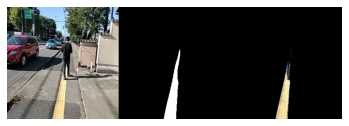

250/250 [==============================] - 197s 790ms/step - loss: 0.0226 - mean_iou: 0.9562 - val_loss: 0.1435 - val_mean_iou: 0.7496
Epoch 16/50
  9/250 [>.............................] - ETA: 2:39 - loss: 0.0206 - mean_iou: 0.9599

 19/250 [=>............................] - ETA: 2:32 - loss: 0.0203 - mean_iou: 0.9605

 29/250 [==>...........................] - ETA: 2:26 - loss: 0.0208 - mean_iou: 0.9595

 39/250 [===>..........................] - ETA: 2:20 - loss: 0.0210 - mean_iou: 0.9591

 49/250 [====>.........................] - ETA: 2:16 - loss: 0.0207 - mean_iou: 0.9598

 59/250 [======>.......................] - ETA: 2:09 - loss: 0.0208 - mean_iou: 0.9596

 69/250 [=======>......................] - ETA: 2:01 - loss: 0.0210 - mean_iou: 0.9591

 79/250 [========>.....................] - ETA: 1:55 - loss: 0.0209 - mean_iou: 0.9594

 89/250 [=========>....................] - ETA: 1:48 - loss: 0.0207 - mean_iou: 0.9597

 99/250 [==========>...................] - ETA: 1:41 - loss: 0.0206 - mean_iou: 0.9599

109/250 [============>.................] - ETA: 1:35 - loss: 0.0206 - mean_iou: 0.9599

119/250 [=============>................] - ETA: 1:28 - loss: 0.0206 - mean_iou: 0.9599

129/250 [==============>...............] - ETA: 1:21 - loss: 0.0205 - mean_iou: 0.9600

139/250 [===============>..............] - ETA: 1:14 - loss: 0.0208 - mean_iou: 0.9594

149/250 [================>.............] - ETA: 1:07 - loss: 0.0209 - mean_iou: 0.9594

159/250 [==================>...........] - ETA: 1:01 - loss: 0.0209 - mean_iou: 0.9594

169/250 [===================>..........] - ETA: 54s - loss: 0.0209 - mean_iou: 0.9594

179/250 [====================>.........] - ETA: 47s - loss: 0.0209 - mean_iou: 0.9594

189/250 [=====================>........] - ETA: 41s - loss: 0.0208 - mean_iou: 0.9594

199/250 [======================>.......] - ETA: 34s - loss: 0.0207 - mean_iou: 0.9597

209/250 [========================>.....] - ETA: 27s - loss: 0.0206 - mean_iou: 0.9599

219/250 [=========================>....] - ETA: 20s - loss: 0.0207 - mean_iou: 0.9597

229/250 [==========================>...] - ETA: 14s - loss: 0.0207 - mean_iou: 0.9598

239/250 [===========================>..] - ETA: 7s - loss: 0.0206 - mean_iou: 0.9599

249/250 [============================>.] - ETA: 0s - loss: 0.0205 - mean_iou: 0.9600

1/1 [==============================] - 0s 22ms/step


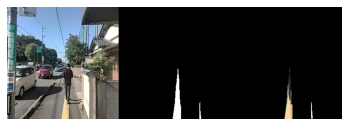

250/250 [==============================] - 198s 794ms/step - loss: 0.0205 - mean_iou: 0.9601 - val_loss: 0.1310 - val_mean_iou: 0.7689
Epoch 17/50
  9/250 [>.............................] - ETA: 2:56 - loss: 0.0230 - mean_iou: 0.9554

 19/250 [=>............................] - ETA: 2:39 - loss: 0.0260 - mean_iou: 0.9498

 29/250 [==>...........................] - ETA: 2:29 - loss: 0.0247 - mean_iou: 0.9523

 39/250 [===>..........................] - ETA: 2:21 - loss: 0.0238 - mean_iou: 0.9540

 49/250 [====>.........................] - ETA: 2:14 - loss: 0.0235 - mean_iou: 0.9545

 59/250 [======>.......................] - ETA: 2:07 - loss: 0.0232 - mean_iou: 0.9551

 69/250 [=======>......................] - ETA: 2:01 - loss: 0.0232 - mean_iou: 0.9551

 79/250 [========>.....................] - ETA: 1:54 - loss: 0.0238 - mean_iou: 0.9539

 89/250 [=========>....................] - ETA: 1:47 - loss: 0.0238 - mean_iou: 0.9539

 99/250 [==========>...................] - ETA: 1:40 - loss: 0.0233 - mean_iou: 0.9548

109/250 [============>.................] - ETA: 1:33 - loss: 0.0235 - mean_iou: 0.9544

119/250 [=============>................] - ETA: 1:27 - loss: 0.0232 - mean_iou: 0.9549

129/250 [==============>...............] - ETA: 1:20 - loss: 0.0233 - mean_iou: 0.9547

139/250 [===============>..............] - ETA: 1:14 - loss: 0.0233 - mean_iou: 0.9548

149/250 [================>.............] - ETA: 1:07 - loss: 0.0231 - mean_iou: 0.9552

159/250 [==================>...........] - ETA: 1:00 - loss: 0.0229 - mean_iou: 0.9555

169/250 [===================>..........] - ETA: 53s - loss: 0.0228 - mean_iou: 0.9557

179/250 [====================>.........] - ETA: 47s - loss: 0.0226 - mean_iou: 0.9561

189/250 [=====================>........] - ETA: 40s - loss: 0.0225 - mean_iou: 0.9563

199/250 [======================>.......] - ETA: 33s - loss: 0.0224 - mean_iou: 0.9566

209/250 [========================>.....] - ETA: 27s - loss: 0.0224 - mean_iou: 0.9565

219/250 [=========================>....] - ETA: 20s - loss: 0.0223 - mean_iou: 0.9566

229/250 [==========================>...] - ETA: 13s - loss: 0.0222 - mean_iou: 0.9569

239/250 [===========================>..] - ETA: 7s - loss: 0.0223 - mean_iou: 0.9568

249/250 [============================>.] - ETA: 0s - loss: 0.0222 - mean_iou: 0.9568

1/1 [==============================] - 0s 22ms/step


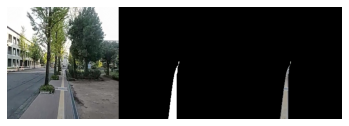

250/250 [==============================] - 197s 786ms/step - loss: 0.0222 - mean_iou: 0.9568 - val_loss: 0.1375 - val_mean_iou: 0.7587
Epoch 18/50
  9/250 [>.............................] - ETA: 2:37 - loss: 0.0208 - mean_iou: 0.9596

 19/250 [=>............................] - ETA: 2:39 - loss: 0.0241 - mean_iou: 0.9532

 29/250 [==>...........................] - ETA: 2:29 - loss: 0.0243 - mean_iou: 0.9529

 39/250 [===>..........................] - ETA: 2:21 - loss: 0.0241 - mean_iou: 0.9534

 49/250 [====>.........................] - ETA: 2:13 - loss: 0.0241 - mean_iou: 0.9534

 59/250 [======>.......................] - ETA: 2:06 - loss: 0.0231 - mean_iou: 0.9552

 69/250 [=======>......................] - ETA: 1:59 - loss: 0.0233 - mean_iou: 0.9549

 79/250 [========>.....................] - ETA: 1:53 - loss: 0.0237 - mean_iou: 0.9540

 89/250 [=========>....................] - ETA: 1:47 - loss: 0.0235 - mean_iou: 0.9544

 99/250 [==========>...................] - ETA: 1:40 - loss: 0.0232 - mean_iou: 0.9550

109/250 [============>.................] - ETA: 1:33 - loss: 0.0236 - mean_iou: 0.9542

119/250 [=============>................] - ETA: 1:26 - loss: 0.0235 - mean_iou: 0.9544

129/250 [==============>...............] - ETA: 1:20 - loss: 0.0239 - mean_iou: 0.9537

139/250 [===============>..............] - ETA: 1:13 - loss: 0.0236 - mean_iou: 0.9543

149/250 [================>.............] - ETA: 1:07 - loss: 0.0235 - mean_iou: 0.9544

159/250 [==================>...........] - ETA: 1:00 - loss: 0.0236 - mean_iou: 0.9543

169/250 [===================>..........] - ETA: 53s - loss: 0.0236 - mean_iou: 0.9542

179/250 [====================>.........] - ETA: 47s - loss: 0.0235 - mean_iou: 0.9544

189/250 [=====================>........] - ETA: 40s - loss: 0.0235 - mean_iou: 0.9544

199/250 [======================>.......] - ETA: 33s - loss: 0.0234 - mean_iou: 0.9547

209/250 [========================>.....] - ETA: 27s - loss: 0.0232 - mean_iou: 0.9549

219/250 [=========================>....] - ETA: 20s - loss: 0.0232 - mean_iou: 0.9551

229/250 [==========================>...] - ETA: 13s - loss: 0.0230 - mean_iou: 0.9553

239/250 [===========================>..] - ETA: 7s - loss: 0.0231 - mean_iou: 0.9551

249/250 [============================>.] - ETA: 0s - loss: 0.0231 - mean_iou: 0.9552

1/1 [==============================] - 0s 24ms/step


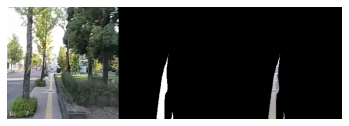

250/250 [==============================] - 208s 832ms/step - loss: 0.0231 - mean_iou: 0.9553 - val_loss: 0.1192 - val_mean_iou: 0.7874
Epoch 19/50
  9/250 [>.............................] - ETA: 2:35 - loss: 0.0187 - mean_iou: 0.9634

 19/250 [=>............................] - ETA: 2:37 - loss: 0.0186 - mean_iou: 0.9637

 29/250 [==>...........................] - ETA: 2:28 - loss: 0.0194 - mean_iou: 0.9622

 39/250 [===>..........................] - ETA: 2:20 - loss: 0.0202 - mean_iou: 0.9607

 49/250 [====>.........................] - ETA: 2:13 - loss: 0.0205 - mean_iou: 0.9600

 59/250 [======>.......................] - ETA: 2:06 - loss: 0.0203 - mean_iou: 0.9605

 69/250 [=======>......................] - ETA: 1:59 - loss: 0.0208 - mean_iou: 0.9594

 79/250 [========>.....................] - ETA: 1:54 - loss: 0.0207 - mean_iou: 0.9597

 89/250 [=========>....................] - ETA: 1:47 - loss: 0.0208 - mean_iou: 0.9596

 99/250 [==========>...................] - ETA: 1:40 - loss: 0.0204 - mean_iou: 0.9602

109/250 [============>.................] - ETA: 1:33 - loss: 0.0203 - mean_iou: 0.9604

119/250 [=============>................] - ETA: 1:26 - loss: 0.0204 - mean_iou: 0.9603

129/250 [==============>...............] - ETA: 1:20 - loss: 0.0203 - mean_iou: 0.9605

139/250 [===============>..............] - ETA: 1:14 - loss: 0.0202 - mean_iou: 0.9606

149/250 [================>.............] - ETA: 1:07 - loss: 0.0201 - mean_iou: 0.9609

159/250 [==================>...........] - ETA: 1:00 - loss: 0.0200 - mean_iou: 0.9611

169/250 [===================>..........] - ETA: 53s - loss: 0.0200 - mean_iou: 0.9610

179/250 [====================>.........] - ETA: 47s - loss: 0.0202 - mean_iou: 0.9606

189/250 [=====================>........] - ETA: 40s - loss: 0.0204 - mean_iou: 0.9603

199/250 [======================>.......] - ETA: 34s - loss: 0.0206 - mean_iou: 0.9600

209/250 [========================>.....] - ETA: 27s - loss: 0.0205 - mean_iou: 0.9600

219/250 [=========================>....] - ETA: 20s - loss: 0.0204 - mean_iou: 0.9603

229/250 [==========================>...] - ETA: 14s - loss: 0.0206 - mean_iou: 0.9599

239/250 [===========================>..] - ETA: 7s - loss: 0.0207 - mean_iou: 0.9598

249/250 [============================>.] - ETA: 0s - loss: 0.0207 - mean_iou: 0.9597

1/1 [==============================] - 0s 22ms/step


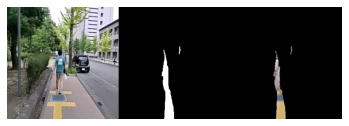

250/250 [==============================] - 197s 788ms/step - loss: 0.0207 - mean_iou: 0.9596 - val_loss: 0.1331 - val_mean_iou: 0.7656
Epoch 20/50
  9/250 [>.............................] - ETA: 2:38 - loss: 0.0224 - mean_iou: 0.9563

 19/250 [=>............................] - ETA: 2:30 - loss: 0.0219 - mean_iou: 0.9574

 29/250 [==>...........................] - ETA: 2:24 - loss: 0.0222 - mean_iou: 0.9568

 39/250 [===>..........................] - ETA: 2:17 - loss: 0.0211 - mean_iou: 0.9590

 49/250 [====>.........................] - ETA: 2:13 - loss: 0.0225 - mean_iou: 0.9563

 59/250 [======>.......................] - ETA: 2:06 - loss: 0.0229 - mean_iou: 0.9556

 69/250 [=======>......................] - ETA: 2:00 - loss: 0.0227 - mean_iou: 0.9558

 79/250 [========>.....................] - ETA: 1:53 - loss: 0.0230 - mean_iou: 0.9554

 89/250 [=========>....................] - ETA: 1:46 - loss: 0.0229 - mean_iou: 0.9554

 99/250 [==========>...................] - ETA: 1:39 - loss: 0.0225 - mean_iou: 0.9562

109/250 [============>.................] - ETA: 1:33 - loss: 0.0222 - mean_iou: 0.9568

119/250 [=============>................] - ETA: 1:27 - loss: 0.0220 - mean_iou: 0.9572

129/250 [==============>...............] - ETA: 1:20 - loss: 0.0217 - mean_iou: 0.9577

139/250 [===============>..............] - ETA: 1:13 - loss: 0.0220 - mean_iou: 0.9573

149/250 [================>.............] - ETA: 1:06 - loss: 0.0219 - mean_iou: 0.9575

159/250 [==================>...........] - ETA: 1:00 - loss: 0.0216 - mean_iou: 0.9580

169/250 [===================>..........] - ETA: 53s - loss: 0.0216 - mean_iou: 0.9580

179/250 [====================>.........] - ETA: 47s - loss: 0.0216 - mean_iou: 0.9580

189/250 [=====================>........] - ETA: 40s - loss: 0.0216 - mean_iou: 0.9581

199/250 [======================>.......] - ETA: 33s - loss: 0.0216 - mean_iou: 0.9579

209/250 [========================>.....] - ETA: 27s - loss: 0.0217 - mean_iou: 0.9578

219/250 [=========================>....] - ETA: 20s - loss: 0.0217 - mean_iou: 0.9578

229/250 [==========================>...] - ETA: 14s - loss: 0.0217 - mean_iou: 0.9578

239/250 [===========================>..] - ETA: 7s - loss: 0.0220 - mean_iou: 0.9573

249/250 [============================>.] - ETA: 0s - loss: 0.0219 - mean_iou: 0.9573

1/1 [==============================] - 0s 22ms/step


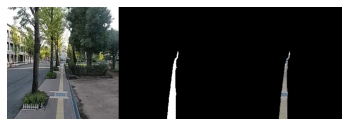

250/250 [==============================] - 208s 833ms/step - loss: 0.0219 - mean_iou: 0.9573 - val_loss: 0.1339 - val_mean_iou: 0.7644
Epoch 21/50
  9/250 [>.............................] - ETA: 2:36 - loss: 0.0239 - mean_iou: 0.9537

 19/250 [=>............................] - ETA: 2:30 - loss: 0.0223 - mean_iou: 0.9566

 29/250 [==>...........................] - ETA: 2:24 - loss: 0.0219 - mean_iou: 0.9574

 39/250 [===>..........................] - ETA: 2:21 - loss: 0.0215 - mean_iou: 0.9581

 49/250 [====>.........................] - ETA: 2:13 - loss: 0.0212 - mean_iou: 0.9587

 59/250 [======>.......................] - ETA: 2:06 - loss: 0.0213 - mean_iou: 0.9586

 69/250 [=======>......................] - ETA: 1:59 - loss: 0.0210 - mean_iou: 0.9591

 79/250 [========>.....................] - ETA: 1:53 - loss: 0.0209 - mean_iou: 0.9593

 89/250 [=========>....................] - ETA: 1:46 - loss: 0.0207 - mean_iou: 0.9596

 99/250 [==========>...................] - ETA: 1:40 - loss: 0.0209 - mean_iou: 0.9593

109/250 [============>.................] - ETA: 1:33 - loss: 0.0209 - mean_iou: 0.9593

119/250 [=============>................] - ETA: 1:26 - loss: 0.0207 - mean_iou: 0.9596

129/250 [==============>...............] - ETA: 1:20 - loss: 0.0208 - mean_iou: 0.9595

139/250 [===============>..............] - ETA: 1:13 - loss: 0.0209 - mean_iou: 0.9592

149/250 [================>.............] - ETA: 1:06 - loss: 0.0208 - mean_iou: 0.9594

159/250 [==================>...........] - ETA: 1:00 - loss: 0.0208 - mean_iou: 0.9594

169/250 [===================>..........] - ETA: 53s - loss: 0.0209 - mean_iou: 0.9592

179/250 [====================>.........] - ETA: 47s - loss: 0.0209 - mean_iou: 0.9594

189/250 [=====================>........] - ETA: 40s - loss: 0.0207 - mean_iou: 0.9597

199/250 [======================>.......] - ETA: 33s - loss: 0.0205 - mean_iou: 0.9600

209/250 [========================>.....] - ETA: 27s - loss: 0.0205 - mean_iou: 0.9600

219/250 [=========================>....] - ETA: 20s - loss: 0.0205 - mean_iou: 0.9601

229/250 [==========================>...] - ETA: 14s - loss: 0.0203 - mean_iou: 0.9604

239/250 [===========================>..] - ETA: 7s - loss: 0.0204 - mean_iou: 0.9603

249/250 [============================>.] - ETA: 0s - loss: 0.0203 - mean_iou: 0.9604

1/1 [==============================] - 0s 22ms/step


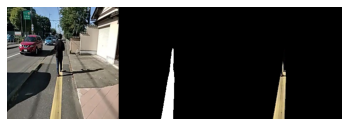

250/250 [==============================] - 208s 831ms/step - loss: 0.0203 - mean_iou: 0.9604 - val_loss: 0.1324 - val_mean_iou: 0.7667
Epoch 22/50
  9/250 [>.............................] - ETA: 2:37 - loss: 0.0253 - mean_iou: 0.9509

 19/250 [=>............................] - ETA: 2:30 - loss: 0.0245 - mean_iou: 0.9525

 29/250 [==>...........................] - ETA: 2:28 - loss: 0.0230 - mean_iou: 0.9553

 39/250 [===>..........................] - ETA: 2:20 - loss: 0.0221 - mean_iou: 0.9570

 49/250 [====>.........................] - ETA: 2:13 - loss: 0.0217 - mean_iou: 0.9579

 59/250 [======>.......................] - ETA: 2:06 - loss: 0.0211 - mean_iou: 0.9589

 69/250 [=======>......................] - ETA: 1:59 - loss: 0.0218 - mean_iou: 0.9576

 79/250 [========>.....................] - ETA: 1:52 - loss: 0.0213 - mean_iou: 0.9586

 89/250 [=========>....................] - ETA: 1:47 - loss: 0.0215 - mean_iou: 0.9582

 99/250 [==========>...................] - ETA: 1:40 - loss: 0.0213 - mean_iou: 0.9585

109/250 [============>.................] - ETA: 1:33 - loss: 0.0210 - mean_iou: 0.9590

119/250 [=============>................] - ETA: 1:26 - loss: 0.0213 - mean_iou: 0.9586

129/250 [==============>...............] - ETA: 1:20 - loss: 0.0212 - mean_iou: 0.9588

139/250 [===============>..............] - ETA: 1:13 - loss: 0.0212 - mean_iou: 0.9587

149/250 [================>.............] - ETA: 1:07 - loss: 0.0215 - mean_iou: 0.9582

159/250 [==================>...........] - ETA: 1:00 - loss: 0.0214 - mean_iou: 0.9584

169/250 [===================>..........] - ETA: 54s - loss: 0.0212 - mean_iou: 0.9587

179/250 [====================>.........] - ETA: 47s - loss: 0.0210 - mean_iou: 0.9591

189/250 [=====================>........] - ETA: 40s - loss: 0.0209 - mean_iou: 0.9593

199/250 [======================>.......] - ETA: 33s - loss: 0.0209 - mean_iou: 0.9593

209/250 [========================>.....] - ETA: 27s - loss: 0.0208 - mean_iou: 0.9595

219/250 [=========================>....] - ETA: 20s - loss: 0.0207 - mean_iou: 0.9597

229/250 [==========================>...] - ETA: 14s - loss: 0.0205 - mean_iou: 0.9600

239/250 [===========================>..] - ETA: 7s - loss: 0.0205 - mean_iou: 0.9600

249/250 [============================>.] - ETA: 0s - loss: 0.0206 - mean_iou: 0.9599

1/1 [==============================] - 0s 22ms/step


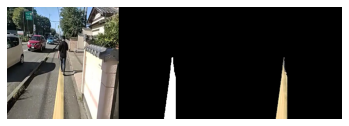

250/250 [==============================] - 208s 831ms/step - loss: 0.0206 - mean_iou: 0.9599 - val_loss: 0.1252 - val_mean_iou: 0.7781
Epoch 23/50
  9/250 [>.............................] - ETA: 2:37 - loss: 0.0206 - mean_iou: 0.9599

 19/250 [=>............................] - ETA: 2:34 - loss: 0.0203 - mean_iou: 0.9604

 29/250 [==>...........................] - ETA: 2:29 - loss: 0.0210 - mean_iou: 0.9591

 39/250 [===>..........................] - ETA: 2:21 - loss: 0.0212 - mean_iou: 0.9588

 49/250 [====>.........................] - ETA: 2:14 - loss: 0.0205 - mean_iou: 0.9600

 59/250 [======>.......................] - ETA: 2:06 - loss: 0.0205 - mean_iou: 0.9600

 69/250 [=======>......................] - ETA: 2:00 - loss: 0.0207 - mean_iou: 0.9597

 79/250 [========>.....................] - ETA: 1:53 - loss: 0.0207 - mean_iou: 0.9597

 89/250 [=========>....................] - ETA: 1:47 - loss: 0.0208 - mean_iou: 0.9595

 99/250 [==========>...................] - ETA: 1:40 - loss: 0.0206 - mean_iou: 0.9598

109/250 [============>.................] - ETA: 1:34 - loss: 0.0207 - mean_iou: 0.9596

119/250 [=============>................] - ETA: 1:27 - loss: 0.0204 - mean_iou: 0.9602

129/250 [==============>...............] - ETA: 1:20 - loss: 0.0206 - mean_iou: 0.9598

139/250 [===============>..............] - ETA: 1:14 - loss: 0.0209 - mean_iou: 0.9592

149/250 [================>.............] - ETA: 1:07 - loss: 0.0208 - mean_iou: 0.9596

159/250 [==================>...........] - ETA: 1:00 - loss: 0.0208 - mean_iou: 0.9594

169/250 [===================>..........] - ETA: 54s - loss: 0.0210 - mean_iou: 0.9590

179/250 [====================>.........] - ETA: 47s - loss: 0.0211 - mean_iou: 0.9590

189/250 [=====================>........] - ETA: 40s - loss: 0.0210 - mean_iou: 0.9591

199/250 [======================>.......] - ETA: 34s - loss: 0.0209 - mean_iou: 0.9593

209/250 [========================>.....] - ETA: 27s - loss: 0.0208 - mean_iou: 0.9595

219/250 [=========================>....] - ETA: 20s - loss: 0.0207 - mean_iou: 0.9596

229/250 [==========================>...] - ETA: 14s - loss: 0.0206 - mean_iou: 0.9598

239/250 [===========================>..] - ETA: 7s - loss: 0.0205 - mean_iou: 0.9600

249/250 [============================>.] - ETA: 0s - loss: 0.0205 - mean_iou: 0.9600

1/1 [==============================] - 0s 37ms/step


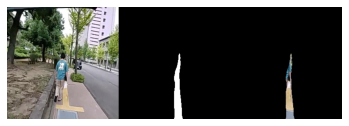

250/250 [==============================] - 197s 788ms/step - loss: 0.0206 - mean_iou: 0.9599 - val_loss: 0.1232 - val_mean_iou: 0.7813
Epoch 24/50
  9/250 [>.............................] - ETA: 2:37 - loss: 0.0223 - mean_iou: 0.9567

 19/250 [=>............................] - ETA: 2:30 - loss: 0.0200 - mean_iou: 0.9609

 29/250 [==>...........................] - ETA: 2:29 - loss: 0.0188 - mean_iou: 0.9632

 39/250 [===>..........................] - ETA: 2:21 - loss: 0.0186 - mean_iou: 0.9637

 49/250 [====>.........................] - ETA: 2:13 - loss: 0.0192 - mean_iou: 0.9624

 59/250 [======>.......................] - ETA: 2:06 - loss: 0.0195 - mean_iou: 0.9619

 69/250 [=======>......................] - ETA: 1:59 - loss: 0.0193 - mean_iou: 0.9622

 79/250 [========>.....................] - ETA: 1:53 - loss: 0.0190 - mean_iou: 0.9628

 89/250 [=========>....................] - ETA: 1:47 - loss: 0.0189 - mean_iou: 0.9630

 99/250 [==========>...................] - ETA: 1:41 - loss: 0.0194 - mean_iou: 0.9620

109/250 [============>.................] - ETA: 1:34 - loss: 0.0193 - mean_iou: 0.9622

119/250 [=============>................] - ETA: 1:27 - loss: 0.0194 - mean_iou: 0.9622

129/250 [==============>...............] - ETA: 1:21 - loss: 0.0194 - mean_iou: 0.9622

139/250 [===============>..............] - ETA: 1:14 - loss: 0.0192 - mean_iou: 0.9625

149/250 [================>.............] - ETA: 1:07 - loss: 0.0192 - mean_iou: 0.9625

159/250 [==================>...........] - ETA: 1:00 - loss: 0.0192 - mean_iou: 0.9625

169/250 [===================>..........] - ETA: 53s - loss: 0.0193 - mean_iou: 0.9622

179/250 [====================>.........] - ETA: 47s - loss: 0.0195 - mean_iou: 0.9620

189/250 [=====================>........] - ETA: 40s - loss: 0.0195 - mean_iou: 0.9620

199/250 [======================>.......] - ETA: 34s - loss: 0.0193 - mean_iou: 0.9623

209/250 [========================>.....] - ETA: 27s - loss: 0.0194 - mean_iou: 0.9622

219/250 [=========================>....] - ETA: 20s - loss: 0.0193 - mean_iou: 0.9624

229/250 [==========================>...] - ETA: 13s - loss: 0.0195 - mean_iou: 0.9620

239/250 [===========================>..] - ETA: 7s - loss: 0.0195 - mean_iou: 0.9619

249/250 [============================>.] - ETA: 0s - loss: 0.0195 - mean_iou: 0.9619

1/1 [==============================] - 0s 22ms/step


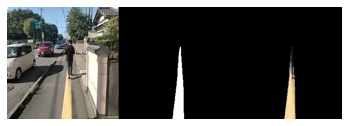

250/250 [==============================] - 208s 833ms/step - loss: 0.0195 - mean_iou: 0.9619 - val_loss: 0.1260 - val_mean_iou: 0.7766
Epoch 25/50
  9/250 [>.............................] - ETA: 2:36 - loss: 0.0167 - mean_iou: 0.9672

 19/250 [=>............................] - ETA: 2:30 - loss: 0.0174 - mean_iou: 0.9659

 29/250 [==>...........................] - ETA: 2:23 - loss: 0.0182 - mean_iou: 0.9644

 39/250 [===>..........................] - ETA: 2:17 - loss: 0.0185 - mean_iou: 0.9638

 49/250 [====>.........................] - ETA: 2:13 - loss: 0.0185 - mean_iou: 0.9639

 59/250 [======>.......................] - ETA: 2:06 - loss: 0.0183 - mean_iou: 0.9642

 69/250 [=======>......................] - ETA: 1:59 - loss: 0.0188 - mean_iou: 0.9632

 79/250 [========>.....................] - ETA: 1:54 - loss: 0.0189 - mean_iou: 0.9630

 89/250 [=========>....................] - ETA: 1:47 - loss: 0.0190 - mean_iou: 0.9629

 99/250 [==========>...................] - ETA: 1:40 - loss: 0.0189 - mean_iou: 0.9631

109/250 [============>.................] - ETA: 1:34 - loss: 0.0189 - mean_iou: 0.9630

119/250 [=============>................] - ETA: 1:27 - loss: 0.0189 - mean_iou: 0.9631

129/250 [==============>...............] - ETA: 1:20 - loss: 0.0186 - mean_iou: 0.9636

139/250 [===============>..............] - ETA: 1:13 - loss: 0.0192 - mean_iou: 0.9626

149/250 [================>.............] - ETA: 1:07 - loss: 0.0193 - mean_iou: 0.9624

159/250 [==================>...........] - ETA: 1:00 - loss: 0.0192 - mean_iou: 0.9626

169/250 [===================>..........] - ETA: 54s - loss: 0.0191 - mean_iou: 0.9628

179/250 [====================>.........] - ETA: 47s - loss: 0.0190 - mean_iou: 0.9630

189/250 [=====================>........] - ETA: 40s - loss: 0.0189 - mean_iou: 0.9630

199/250 [======================>.......] - ETA: 33s - loss: 0.0189 - mean_iou: 0.9631

209/250 [========================>.....] - ETA: 27s - loss: 0.0190 - mean_iou: 0.9629

219/250 [=========================>....] - ETA: 20s - loss: 0.0192 - mean_iou: 0.9626

229/250 [==========================>...] - ETA: 14s - loss: 0.0191 - mean_iou: 0.9628

239/250 [===========================>..] - ETA: 7s - loss: 0.0192 - mean_iou: 0.9626

249/250 [============================>.] - ETA: 0s - loss: 0.0191 - mean_iou: 0.9626

1/1 [==============================] - 0s 22ms/step


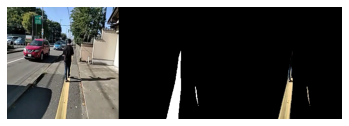

250/250 [==============================] - 208s 831ms/step - loss: 0.0191 - mean_iou: 0.9627 - val_loss: 0.1334 - val_mean_iou: 0.7650
Epoch 26/50
  9/250 [>.............................] - ETA: 2:36 - loss: 0.0165 - mean_iou: 0.9676

 19/250 [=>............................] - ETA: 2:30 - loss: 0.0181 - mean_iou: 0.9645

 29/250 [==>...........................] - ETA: 2:23 - loss: 0.0175 - mean_iou: 0.9657

 39/250 [===>..........................] - ETA: 2:20 - loss: 0.0180 - mean_iou: 0.9647

 49/250 [====>.........................] - ETA: 2:16 - loss: 0.0183 - mean_iou: 0.9643

 59/250 [======>.......................] - ETA: 2:08 - loss: 0.0185 - mean_iou: 0.9638

 69/250 [=======>......................] - ETA: 2:01 - loss: 0.0186 - mean_iou: 0.9636

 79/250 [========>.....................] - ETA: 1:54 - loss: 0.0184 - mean_iou: 0.9639

 89/250 [=========>....................] - ETA: 1:47 - loss: 0.0183 - mean_iou: 0.9642

 99/250 [==========>...................] - ETA: 1:40 - loss: 0.0182 - mean_iou: 0.9643

109/250 [============>.................] - ETA: 1:34 - loss: 0.0180 - mean_iou: 0.9647

119/250 [=============>................] - ETA: 1:27 - loss: 0.0184 - mean_iou: 0.9640

129/250 [==============>...............] - ETA: 1:20 - loss: 0.0183 - mean_iou: 0.9642

139/250 [===============>..............] - ETA: 1:13 - loss: 0.0183 - mean_iou: 0.9641

149/250 [================>.............] - ETA: 1:07 - loss: 0.0184 - mean_iou: 0.9639

159/250 [==================>...........] - ETA: 1:00 - loss: 0.0187 - mean_iou: 0.9634

169/250 [===================>..........] - ETA: 53s - loss: 0.0189 - mean_iou: 0.9630

179/250 [====================>.........] - ETA: 47s - loss: 0.0191 - mean_iou: 0.9627

189/250 [=====================>........] - ETA: 40s - loss: 0.0190 - mean_iou: 0.9629

199/250 [======================>.......] - ETA: 33s - loss: 0.0189 - mean_iou: 0.9630

209/250 [========================>.....] - ETA: 27s - loss: 0.0190 - mean_iou: 0.9629

219/250 [=========================>....] - ETA: 20s - loss: 0.0190 - mean_iou: 0.9630

229/250 [==========================>...] - ETA: 13s - loss: 0.0189 - mean_iou: 0.9630

239/250 [===========================>..] - ETA: 7s - loss: 0.0189 - mean_iou: 0.9632

249/250 [============================>.] - ETA: 0s - loss: 0.0187 - mean_iou: 0.9634

1/1 [==============================] - 0s 22ms/step


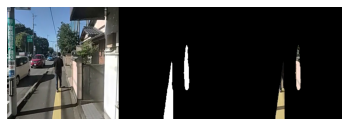

250/250 [==============================] - 196s 786ms/step - loss: 0.0188 - mean_iou: 0.9633 - val_loss: 0.1263 - val_mean_iou: 0.7763
Epoch 27/50
  9/250 [>.............................] - ETA: 2:37 - loss: 0.0232 - mean_iou: 0.9550

 19/250 [=>............................] - ETA: 2:31 - loss: 0.0216 - mean_iou: 0.9580

 29/250 [==>...........................] - ETA: 2:26 - loss: 0.0205 - mean_iou: 0.9602

 39/250 [===>..........................] - ETA: 2:22 - loss: 0.0212 - mean_iou: 0.9588

 49/250 [====>.........................] - ETA: 2:14 - loss: 0.0210 - mean_iou: 0.9592

 59/250 [======>.......................] - ETA: 2:09 - loss: 0.0206 - mean_iou: 0.9598

 69/250 [=======>......................] - ETA: 2:02 - loss: 0.0206 - mean_iou: 0.9598

 79/250 [========>.....................] - ETA: 1:54 - loss: 0.0207 - mean_iou: 0.9596

 89/250 [=========>....................] - ETA: 1:47 - loss: 0.0208 - mean_iou: 0.9595

 99/250 [==========>...................] - ETA: 1:40 - loss: 0.0206 - mean_iou: 0.9598

109/250 [============>.................] - ETA: 1:33 - loss: 0.0203 - mean_iou: 0.9605

119/250 [=============>................] - ETA: 1:27 - loss: 0.0203 - mean_iou: 0.9604

129/250 [==============>...............] - ETA: 1:20 - loss: 0.0203 - mean_iou: 0.9604

139/250 [===============>..............] - ETA: 1:14 - loss: 0.0203 - mean_iou: 0.9604

149/250 [================>.............] - ETA: 1:07 - loss: 0.0204 - mean_iou: 0.9602

159/250 [==================>...........] - ETA: 1:00 - loss: 0.0203 - mean_iou: 0.9605

169/250 [===================>..........] - ETA: 53s - loss: 0.0201 - mean_iou: 0.9609

179/250 [====================>.........] - ETA: 47s - loss: 0.0205 - mean_iou: 0.9600

189/250 [=====================>........] - ETA: 40s - loss: 0.0204 - mean_iou: 0.9603

199/250 [======================>.......] - ETA: 34s - loss: 0.0204 - mean_iou: 0.9602

209/250 [========================>.....] - ETA: 27s - loss: 0.0204 - mean_iou: 0.9603

219/250 [=========================>....] - ETA: 20s - loss: 0.0203 - mean_iou: 0.9604

229/250 [==========================>...] - ETA: 13s - loss: 0.0202 - mean_iou: 0.9607

239/250 [===========================>..] - ETA: 7s - loss: 0.0202 - mean_iou: 0.9606

249/250 [============================>.] - ETA: 0s - loss: 0.0201 - mean_iou: 0.9608

1/1 [==============================] - 0s 22ms/step


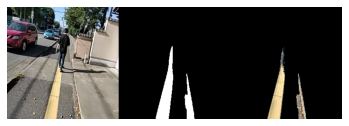

250/250 [==============================] - 196s 786ms/step - loss: 0.0201 - mean_iou: 0.9608 - val_loss: 0.1224 - val_mean_iou: 0.7822
Epoch 28/50
  9/250 [>.............................] - ETA: 3:15 - loss: 0.0187 - mean_iou: 0.9635

 19/250 [=>............................] - ETA: 2:47 - loss: 0.0211 - mean_iou: 0.9589

 29/250 [==>...........................] - ETA: 2:34 - loss: 0.0203 - mean_iou: 0.9605

 39/250 [===>..........................] - ETA: 2:24 - loss: 0.0192 - mean_iou: 0.9624

 49/250 [====>.........................] - ETA: 2:16 - loss: 0.0201 - mean_iou: 0.9608

 59/250 [======>.......................] - ETA: 2:08 - loss: 0.0201 - mean_iou: 0.9608

 69/250 [=======>......................] - ETA: 2:02 - loss: 0.0200 - mean_iou: 0.9610

 79/250 [========>.....................] - ETA: 1:55 - loss: 0.0197 - mean_iou: 0.9615

 89/250 [=========>....................] - ETA: 1:48 - loss: 0.0193 - mean_iou: 0.9623

 99/250 [==========>...................] - ETA: 1:41 - loss: 0.0192 - mean_iou: 0.9624

109/250 [============>.................] - ETA: 1:34 - loss: 0.0191 - mean_iou: 0.9626

119/250 [=============>................] - ETA: 1:27 - loss: 0.0190 - mean_iou: 0.9629

129/250 [==============>...............] - ETA: 1:20 - loss: 0.0195 - mean_iou: 0.9620

139/250 [===============>..............] - ETA: 1:14 - loss: 0.0195 - mean_iou: 0.9620

149/250 [================>.............] - ETA: 1:07 - loss: 0.0193 - mean_iou: 0.9622

159/250 [==================>...........] - ETA: 1:00 - loss: 0.0193 - mean_iou: 0.9623

169/250 [===================>..........] - ETA: 54s - loss: 0.0192 - mean_iou: 0.9624

179/250 [====================>.........] - ETA: 47s - loss: 0.0191 - mean_iou: 0.9626

189/250 [=====================>........] - ETA: 40s - loss: 0.0191 - mean_iou: 0.9627

199/250 [======================>.......] - ETA: 34s - loss: 0.0191 - mean_iou: 0.9628

209/250 [========================>.....] - ETA: 27s - loss: 0.0191 - mean_iou: 0.9627

219/250 [=========================>....] - ETA: 20s - loss: 0.0191 - mean_iou: 0.9627

229/250 [==========================>...] - ETA: 14s - loss: 0.0189 - mean_iou: 0.9630

239/250 [===========================>..] - ETA: 7s - loss: 0.0189 - mean_iou: 0.9631

249/250 [============================>.] - ETA: 0s - loss: 0.0191 - mean_iou: 0.9626

1/1 [==============================] - 0s 36ms/step


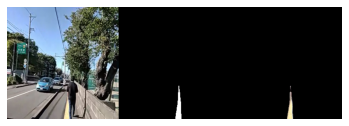

250/250 [==============================] - 208s 832ms/step - loss: 0.0191 - mean_iou: 0.9627 - val_loss: 0.1400 - val_mean_iou: 0.7552
Epoch 29/50
  9/250 [>.............................] - ETA: 2:42 - loss: 0.0158 - mean_iou: 0.9689

 19/250 [=>............................] - ETA: 2:33 - loss: 0.0174 - mean_iou: 0.9659

 29/250 [==>...........................] - ETA: 2:26 - loss: 0.0169 - mean_iou: 0.9669

 39/250 [===>..........................] - ETA: 2:19 - loss: 0.0182 - mean_iou: 0.9644

 49/250 [====>.........................] - ETA: 2:12 - loss: 0.0181 - mean_iou: 0.9646

 59/250 [======>.......................] - ETA: 2:05 - loss: 0.0182 - mean_iou: 0.9644

 69/250 [=======>......................] - ETA: 2:00 - loss: 0.0181 - mean_iou: 0.9646

 79/250 [========>.....................] - ETA: 1:53 - loss: 0.0181 - mean_iou: 0.9646

 89/250 [=========>....................] - ETA: 1:46 - loss: 0.0181 - mean_iou: 0.9646

 99/250 [==========>...................] - ETA: 1:40 - loss: 0.0180 - mean_iou: 0.9647

109/250 [============>.................] - ETA: 1:33 - loss: 0.0183 - mean_iou: 0.9643

119/250 [=============>................] - ETA: 1:26 - loss: 0.0184 - mean_iou: 0.9641

129/250 [==============>...............] - ETA: 1:20 - loss: 0.0186 - mean_iou: 0.9636

139/250 [===============>..............] - ETA: 1:13 - loss: 0.0187 - mean_iou: 0.9634

149/250 [================>.............] - ETA: 1:07 - loss: 0.0186 - mean_iou: 0.9636

159/250 [==================>...........] - ETA: 1:00 - loss: 0.0190 - mean_iou: 0.9629

169/250 [===================>..........] - ETA: 53s - loss: 0.0189 - mean_iou: 0.9631

179/250 [====================>.........] - ETA: 47s - loss: 0.0188 - mean_iou: 0.9632

189/250 [=====================>........] - ETA: 40s - loss: 0.0188 - mean_iou: 0.9632

199/250 [======================>.......] - ETA: 33s - loss: 0.0187 - mean_iou: 0.9634

209/250 [========================>.....] - ETA: 27s - loss: 0.0189 - mean_iou: 0.9631

219/250 [=========================>....] - ETA: 20s - loss: 0.0190 - mean_iou: 0.9629

229/250 [==========================>...] - ETA: 13s - loss: 0.0189 - mean_iou: 0.9630

239/250 [===========================>..] - ETA: 7s - loss: 0.0191 - mean_iou: 0.9626

249/250 [============================>.] - ETA: 0s - loss: 0.0192 - mean_iou: 0.9625

1/1 [==============================] - 0s 22ms/step


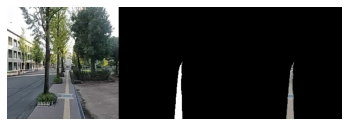

250/250 [==============================] - 208s 831ms/step - loss: 0.0192 - mean_iou: 0.9625 - val_loss: 0.1237 - val_mean_iou: 0.7804
Epoch 30/50
  9/250 [>.............................] - ETA: 2:35 - loss: 0.0230 - mean_iou: 0.9553

 19/250 [=>............................] - ETA: 2:29 - loss: 0.0200 - mean_iou: 0.9609

 29/250 [==>...........................] - ETA: 2:23 - loss: 0.0184 - mean_iou: 0.9640

 39/250 [===>..........................] - ETA: 2:17 - loss: 0.0196 - mean_iou: 0.9617

 49/250 [====>.........................] - ETA: 2:10 - loss: 0.0194 - mean_iou: 0.9621

 59/250 [======>.......................] - ETA: 2:06 - loss: 0.0204 - mean_iou: 0.9603

 69/250 [=======>......................] - ETA: 1:59 - loss: 0.0199 - mean_iou: 0.9612

 79/250 [========>.....................] - ETA: 1:52 - loss: 0.0195 - mean_iou: 0.9620

 89/250 [=========>....................] - ETA: 1:45 - loss: 0.0195 - mean_iou: 0.9619

 99/250 [==========>...................] - ETA: 1:39 - loss: 0.0194 - mean_iou: 0.9621

109/250 [============>.................] - ETA: 1:32 - loss: 0.0197 - mean_iou: 0.9615

119/250 [=============>................] - ETA: 1:26 - loss: 0.0198 - mean_iou: 0.9614

129/250 [==============>...............] - ETA: 1:20 - loss: 0.0197 - mean_iou: 0.9615

139/250 [===============>..............] - ETA: 1:13 - loss: 0.0194 - mean_iou: 0.9621

149/250 [================>.............] - ETA: 1:06 - loss: 0.0193 - mean_iou: 0.9623

159/250 [==================>...........] - ETA: 1:00 - loss: 0.0194 - mean_iou: 0.9622

169/250 [===================>..........] - ETA: 53s - loss: 0.0194 - mean_iou: 0.9621

179/250 [====================>.........] - ETA: 47s - loss: 0.0194 - mean_iou: 0.9622

189/250 [=====================>........] - ETA: 40s - loss: 0.0195 - mean_iou: 0.9619

199/250 [======================>.......] - ETA: 33s - loss: 0.0196 - mean_iou: 0.9618

209/250 [========================>.....] - ETA: 27s - loss: 0.0196 - mean_iou: 0.9618

219/250 [=========================>....] - ETA: 20s - loss: 0.0197 - mean_iou: 0.9615

229/250 [==========================>...] - ETA: 13s - loss: 0.0196 - mean_iou: 0.9618

234/250 [===========================>..] - ETA: 10s - loss: 0.0196 - mean_iou: 0.9618

In [ ]:
training()

if ADDITIONAL_LEARNING:
  model_name = os.path.join(RESULT_DIR, f"{now_time} t={TEST_GROUP:d}:add .h5")
else:
  model_name = os.path.join(RESULT_DIR, f"{now_time} t={TEST_GROUP:d}.h5")

model.save(model_name)

testing()

# TensorBoard

In [ ]:
!cp -r "/content/drive/My Drive/U-Net/logs" "."
%load_ext tensorboard
%tensorboard --logdir logs